In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import warnings
warnings.filterwarnings("ignore")

In [2]:
def aic(y,y_pred, X):
    
    # Compute the residual sum of squares (RSS)
    RSS = np.sum((y - y_pred)**2)

    # Compute the number of parameters in the model
    k = X.shape[1] + 1

    # Compute the AIC score
    AIC = 2*k - 2*np.log(RSS)

    return AIC

### Loading the data:

In [3]:
import os

# set the directory containing the CSV files
directory = 'input data'

# create an empty list to hold all the dataframes
df_list = []

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # read the CSV file into a pandas dataframe
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        
        # append the dataframe to the list
        df_list.append(df)

# concatenate all dataframes in the list into a single dataframe
data = pd.concat(df_list, ignore_index=True)

# print the resulting dataframe
data.head()

,Record ID,Date Time,Solar Avg,Unnamed: 3
0,203.00,01-03-22 0:00,0.00,NaN
1,204.00,01-03-22 0:01,0.00,NaN
2,205.00,01-03-22 0:02,0.00,NaN
3,206.00,01-03-22 0:03,0.00,NaN
4,207.00,01-03-22 0:04,0.00,NaN


In [4]:
data = data.drop(['Record ID','Unnamed: 3'], axis=1)
data.dropna(inplace=True)
data['Date Time'] = pd.to_datetime(data['Date Time'])
data = data.loc[data['Date Time'] <= '2023-03']
data['Date Time'] = data['Date Time'].dt.round('H')
data = data.groupby('Date Time').mean().reset_index()
data.sort_values(by='Date Time',inplace=True)
data.set_index('Date Time', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7651 entries, 2022-01-03 00:00:00 to 2023-03-01 00:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Solar Avg  7651 non-null   float64
dtypes: float64(1)
memory usage: 119.5 KB


data = data.drop(['Record ID','Unnamed: 3'], axis=1): This line drops two columns named 'Record ID' and 'Unnamed: 3' from the DataFrame data. The axis=1 argument specifies that columns should be dropped.

data.dropna(inplace=True): This line drops all rows from the DataFrame data that contain missing (NaN) values. The inplace=True argument specifies that the DataFrame should be modified in place.

data['Date Time'] = pd.to_datetime(data['Date Time']): This line converts the values in the 'Date Time' column of the DataFrame data to datetime objects using the pd.to_datetime() function. This is done so that the values can be easily sorted and indexed later.

data.drop_duplicates(subset='Date Time',inplace=True): This line drops any rows from the DataFrame data that have duplicate values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.sort_values(by='Date Time',inplace=True): This line sorts the rows of the DataFrame data by the values in the 'Date Time' column. The inplace=True argument specifies that the DataFrame should be modified in place.

data.set_index('Date Time', inplace=True): This line sets the 'Date Time' column as the index of the DataFrame data. This means that the DataFrame will be indexed by dates and times, which will be useful for time series analysis.

data.info(): This line prints out some basic information about the DataFrame data, including its shape (number of rows and columns), the data types of its columns, and the number of non-null values in each column.

In [5]:
del df_list

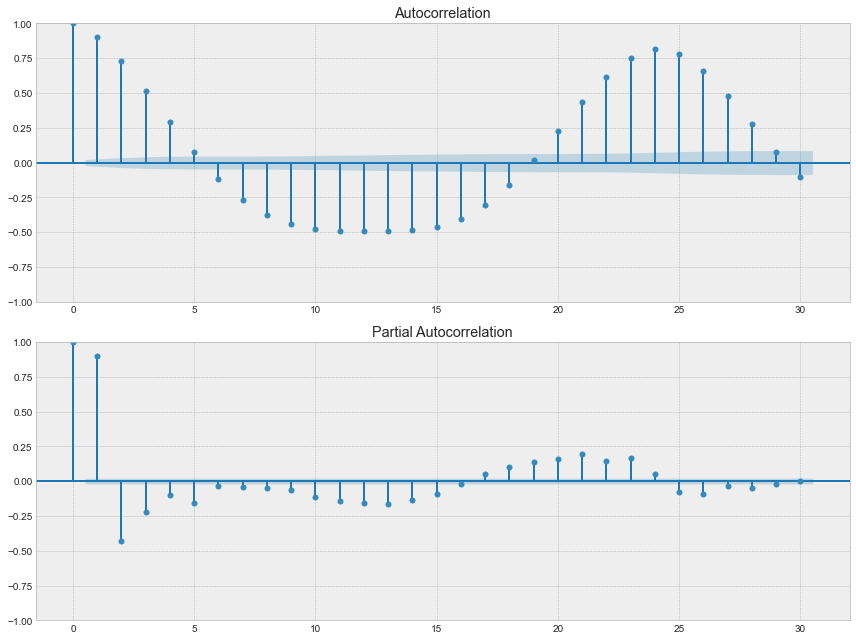

In [6]:
import statsmodels.formula.api as smf        
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

data.sort_index(inplace=True)
with plt.style.context('bmh'):    
    fig = plt.figure(figsize=(12, 9))
    layout = (2, 1)
    acf_ax = plt.subplot2grid(layout, (0, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 0))
    
    smt.graphics.plot_pacf(data['Solar Avg'], ax=pacf_ax,lags=30)
    smt.graphics.plot_acf(data['Solar Avg'], ax=acf_ax,lags=30)
    plt.tight_layout()

This code imports necessary libraries and then creates a figure with two subplots to display the autocorrelation and partial autocorrelation functions for a time series dataset. The sort_index method is called to ensure the data is sorted in the correct order, and then the plot_acf and plot_pacf functions are called to generate the desired plots.

In [7]:
# Genrating needed lags:
for i in range(1,14):
    data["lag_{}".format(i)] = data['Solar Avg'].shift(i)
data.dropna(axis=0,inplace=True)
data.head()

,Solar Avg,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13
Date Time,,,,,,,,,,,,,,
2022-01-03 13:00:00,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00,0.00,0.00
2022-01-03 14:00:00,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00,0.00
2022-01-03 15:00:00,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00,0.00
2022-01-03 16:00:00,396.28,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00,0.00
2022-01-03 17:00:00,195.93,396.28,810.54,955.11,995.37,943.70,959.81,1141.83,690.23,259.15,71.05,0.75,0.00,0.00


#### Plotting the correlations:

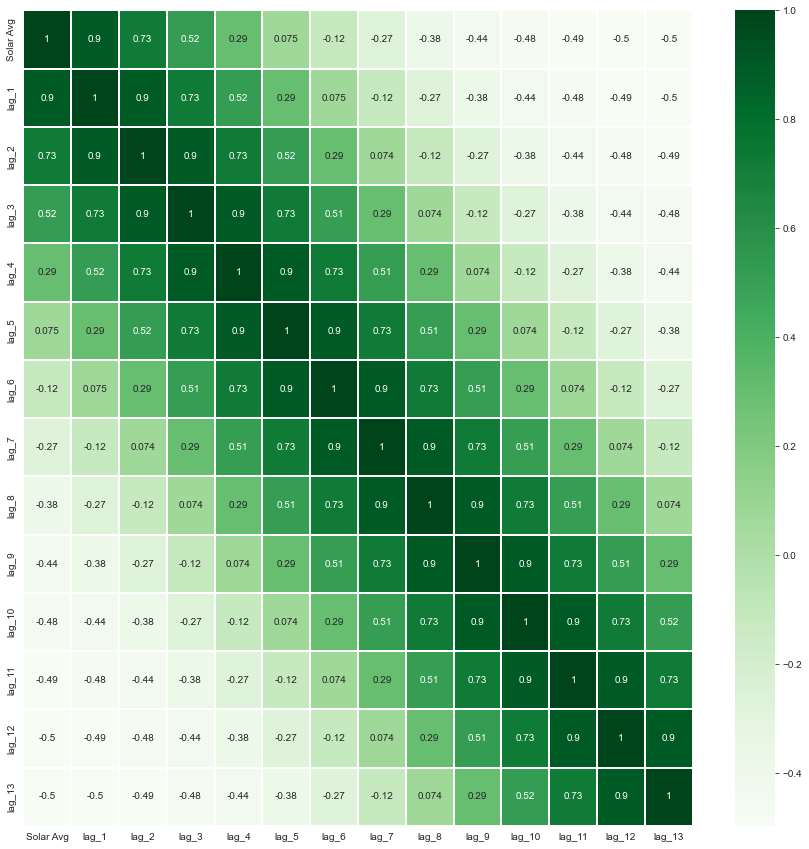

In [8]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), annot=True, cmap="Greens", linewidths=0.1, annot_kws={"fontsize":10});

In [9]:
data.reset_index().to_csv('plotting data/Full Data.csv')